### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:

- just use async langchain, support google vs openai vs anthropic transparently
- use exponential backoff to deal with rate limit issues (using metadata is not really well supported across llm providers, openai only gives time to reset in the http headers and not in the API itelf)
- do tests with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing
- scrape, extract, filter headlines, download pages, summarize, filter, categorize and sort, compose, rewrite


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (newscatcher_sources, fn_initialize, fn_download_sources, fn_extract_urls,
                                 fn_verify_download, fn_extract_newscatcher, fn_extract_newsapi,
                                 fn_filter_urls, fn_topic_clusters, fn_topic_analysis, fn_download_pages, 
                                 fn_summarize_pages, fn_propose_cats,
                                 fn_compose_summary, fn_rewrite_summary, fn_is_revision_complete, fn_send_mail
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:21:42) [Clang 18.1.8 ]
LangChain         0.3.18
OpenAI            1.63.1
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Define LangGraph agent state graph

In [4]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: list[dict]                    #  the current working set of headlines (pandas dataframe not supported)
    before_date: str                    #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool                   #  if False use existing files, else download from sources
    sources: dict                       #  sources to scrap
    sources_reverse: dict[str, str]     #  map file names to sources
    bullets: list[str]                  #  bullet points for summary email
    summary: str                        #  final summary
    cluster_topics: list[str]           #  list of cluster topics
    topics_str: str                     #  edited topics
    n_edits: int                        #  count edit iterations so we don't keep editing forever
    edit_complete: bool                 #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [5]:
# sqlite schema to store previously processed headlines
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [6]:
# some debugging stuff, check a headline is cached properly
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")]
# xdf.loc[xdf["title"].str.startswith("NHTSA")]

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [10]:
class Agent:

    def __init__(self, state):

        self.state = state

        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("verify_download", self.verify_download)
        graph_builder.add_node("extract_newsapi_urls",
                               self.extract_newsapi_urls)
        # graph_builder.add_node("extract_newscatcher_urls",
        #                        self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "verify_download")
        graph_builder.add_edge("verify_download", "extract_newsapi_urls")
        graph_builder.add_edge("extract_newsapi_urls", "filter_urls")
        # graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                             })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories
        # self.conn = sqlite3.connect('lg_checkpointer.db')
        # self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,)
#                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph

    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def verify_download(self, state: AgentState) -> AgentState:
        self.state = fn_verify_download(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        try:
            self.state = fn_extract_newscatcher(state)
        except KeyError:
            log("Newscatcher download failed")
        return self.state

    def extract_newsapi_urls(self, state: AgentState) -> AgentState:
        try:
            self.state = fn_extract_newsapi(state)
        except KeyError:
            log("NewsAPI download failed")
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state

    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values")
        for event in events:
            try:
                if event.get('summary'):
                    print('summary created')
                    display(event.get('summary').replace("$", "\\\\$"))
                elif event.get('bullets'):
                    print('bullets created')
                    display("\n\n".join(
                        event.get('bullets')).replace("$", "\\\\$"))
                elif event.get('cluster_topics'):
                    print('cluster topics created')
                    display("\n\n".join(event.get('cluster_topics')))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby(
                        "src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc:
                print('run exception')
                print(exc)

        return self.state



In [11]:
def initialize_agent(do_download, before_date):
    # initial state
    state = AgentState({
        'AIdf': [{}],
        'before_date': before_date,
        'do_download': do_download,
        'sources': {},
        'sources_reverse': {},
        'bullets': '',
        'summary': '',
        'cluster_topics': [],
        'topics_str': '',
        'n_edits': 0,
        'edit_complete': False,
    })
    thread_id = uuid.uuid4().hex
    log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}"
        )
    return state, Agent(state), thread_id


# Instantiate agent and run LangGraph workflow graph end to end

2025-02-17 20:56:29,383 - AInewsbot - INFO - Initializing with before_date=2025-02-17 12:00, do_download=True, thread_id=7fcad784fba848c0ad4778da5c7721cd
2025-02-17 20:56:29,399 - AInewsbot - INFO - thread_id: 7fcad784fba848c0ad4778da5c7721cd


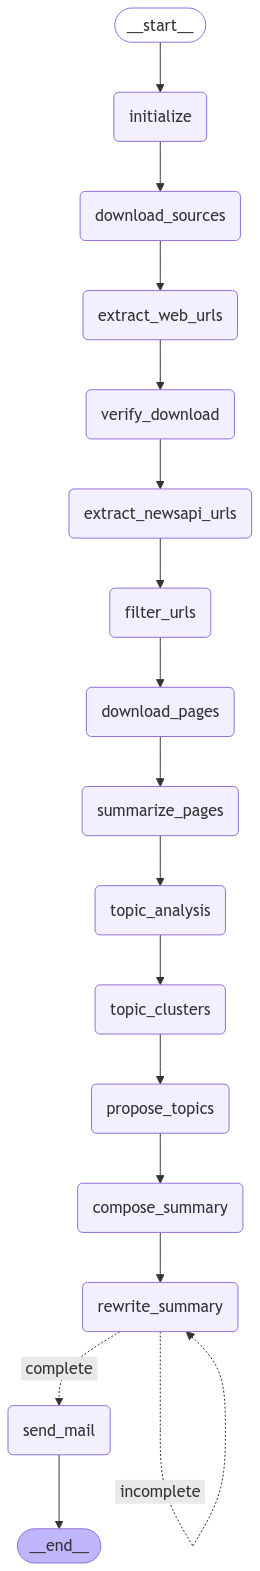

In [12]:
before_date = None
before_date = '2025-02-17 12:00'
do_download = True

state, lg_agent, thread_id = initialize_agent(do_download, before_date)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [13]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(state, config)


2025-02-17 20:57:31,590 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-02-17 20:57:31,592 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2025-02-17 20:57:31,593 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2025-02-17 20:57:31,593 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2025-02-17 20:57:31,593 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2025-02-17 20:57:31,594 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-02-17 20:57:31,594 - AInewsbot - INFO - 

run exception
'src'
run exception
'src'


2025-02-17 20:57:49,098 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-17 20:57:49,098 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-17 20:57:49,098 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-17 20:57:49,098 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-17 20:57:49,100 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-17 20:57:49,101 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-17 20:57:49,101 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-17 20:57:49,101 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-17 20:58:43,846 - AInewsbot - INFO - get_driver - Initialized webdriver
2025-02-17 20:58:43,878 - AInewsbot - INFO - get_driver - Resizing window
2025-02-17 20:58:43,851 - AInewsbot - INFO - get_driver - Initialized webdriver
2025-02-17 20:58:43,890 - AInewsbot - INFO - get_driver - Resi

2025-02-17 21:00:18,307 - AInewsbot - INFO - Downloaded Reddit to htmldata/Reddit multiple subreddits (02_17_2025 08_59_42 PM).html
2025-02-17 21:00:18,308 - AInewsbot - INFO - Downloaded Ars Technica to htmldata/Ars Technica (02_17_2025 08_59_01 PM).html
2025-02-17 21:00:18,308 - AInewsbot - INFO - Downloaded HackerNoon to htmldata/HackerNoon (02_17_2025 08_59_12 PM).html
2025-02-17 21:00:18,308 - AInewsbot - INFO - Downloaded Techmeme to htmldata/Techmeme (02_17_2025 08_59_23 PM).html
2025-02-17 21:00:18,309 - AInewsbot - INFO - Downloaded The Verge to htmldata/The Verge AI (02_17_2025 08_59_35 PM).html
2025-02-17 21:00:18,309 - AInewsbot - INFO - Downloaded WSJ Tech to htmldata/WSJ Technology (02_17_2025 08_59_50 PM).html
2025-02-17 21:00:18,309 - AInewsbot - INFO - Downloaded FT Tech to htmldata/FT Technology (02_17_2025 08_58_57 PM).html
2025-02-17 21:00:18,310 - AInewsbot - INFO - Downloaded Hacker News to htmldata/Hacker News Page 1 (02_17_2025 08_59_08 PM).html
2025-02-17 21:00

run exception
'src'


2025-02-17 21:00:18,548 - AInewsbot - INFO - parse_file - found 262 raw links
2025-02-17 21:00:18,552 - AInewsbot - INFO - parse_file - found 24 filtered links
2025-02-17 21:00:18,552 - AInewsbot - INFO - 24 links found
2025-02-17 21:00:18,552 - AInewsbot - INFO - HackerNoon -> htmldata/HackerNoon (02_17_2025 08_59_12 PM).html
2025-02-17 21:00:19,411 - AInewsbot - INFO - parse_file - found 585 raw links
2025-02-17 21:00:19,419 - AInewsbot - INFO - parse_file - found 99 filtered links
2025-02-17 21:00:19,420 - AInewsbot - INFO - 99 links found
2025-02-17 21:00:19,420 - AInewsbot - INFO - NYT Tech -> htmldata/New York Times Technology (02_17_2025 08_59_20 PM).html
2025-02-17 21:00:19,433 - AInewsbot - INFO - parse_file - found 78 raw links
2025-02-17 21:00:19,434 - AInewsbot - INFO - parse_file - found 19 filtered links
2025-02-17 21:00:19,434 - AInewsbot - INFO - 19 links found
2025-02-17 21:00:19,435 - AInewsbot - INFO - Reddit -> htmldata/Reddit multiple subreddits (02_17_2025 08_59_4

,id
src,
Ars Technica,29
Bloomberg Tech,12
Business Insider,21
FT Tech,65
Feedly AI,36
Hacker News,26
Hacker News 2,24
HackerNoon,98
NYT Tech,19


2025-02-17 21:00:19,736 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,29
Bloomberg Tech,12
Business Insider,21
FT Tech,65
Feedly AI,36
Hacker News,26
Hacker News 2,24
HackerNoon,98
NYT Tech,19


2025-02-17 21:00:19,740 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-02-16T21:00:19 from NewsAPI


,id
src,
Ars Technica,29
Bloomberg Tech,12
Business Insider,21
FT Tech,65
Feedly AI,36
Hacker News,26
Hacker News 2,24
HackerNoon,98
NYT Tech,19


2025-02-17 21:00:20,010 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-02-17 12:00'
2025-02-17 21:00:20,552 - AInewsbot - INFO - URLs in orig_df: 871
2025-02-17 21:00:20,555 - AInewsbot - INFO - Existing URLs in DB: 217681
2025-02-17 21:00:20,606 - AInewsbot - INFO - New URLs in df filtered by URL: 275
2025-02-17 21:00:20,724 - AInewsbot - INFO - Existing src+title: 2
2025-02-17 21:00:20,724 - AInewsbot - INFO - New URLs in df filtered by src+title: 273
2025-02-17 21:00:20,738 - AInewsbot - INFO - Found 273 unique new headlines
2025-02-17 21:00:20,742 - AInewsbot - INFO - Found 264 unique new headlines
2025-02-17 21:00:23,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:00:25,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:00:25,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 20

,id
src,
Bloomberg Tech,1
Feedly AI,28
Hacker News,2
HackerNoon,1
NewsAPI,21
The Register,1
VentureBeat,1


2025-02-17 21:00:37,054 - AInewsbot - INFO - Queuing URLs for scraping
2025-02-17 21:00:37,055 - AInewsbot - INFO - Processing page 0: https://opensea.io/item/base/0xbe6900e9e2fa368ae81c2752b08c98973d856340/247
2025-02-17 21:00:37,056 - AInewsbot - INFO - Processing page 1: https://hackernoon.com/ai-knows-bestbut-only-if-you-agree-with-it
2025-02-17 21:00:37,056 - AInewsbot - INFO - get_url(https://hackernoon.com/ai-knows-bestbut-only-if-you-agree-with-it) - starting get_url https://hackernoon.com/ai-knows-bestbut-only-if-you-agree-with-it
2025-02-17 21:00:37,056 - AInewsbot - INFO - get_url(https://opensea.io/item/base/0xbe6900e9e2fa368ae81c2752b08c98973d856340/247) - starting get_url https://opensea.io/item/base/0xbe6900e9e2fa368ae81c2752b08c98973d856340/247
2025-02-17 21:00:37,056 - AInewsbot - INFO - Processing page 3: https://www.genengnews.com/topics/artificial-intelligence/ai-guided-receptor-engineering-to-improve-performance-in-cell-therapies/
2025-02-17 21:00:37,056 - AInewsbo

2025-02-17 21:00:47,343 - AInewsbot - INFO - get_url(Amazon Reportedly Delaying Updated Alexa Over Incorrect Answers) - Saving Amazon_Reportedly_Delaying_Updated_Alexa_Over_Incorrect_Answers.html as UTF-8
2025-02-17 21:00:47,345 - AInewsbot - INFO - Processing page 14: https://www.geeky-gadgets.com/deepscaler-ai-model-maths/
2025-02-17 21:00:47,346 - AInewsbot - INFO - get_url(https://www.geeky-gadgets.com/deepscaler-ai-model-maths/) - starting get_url https://www.geeky-gadgets.com/deepscaler-ai-model-maths/
2025-02-17 21:00:48,149 - AInewsbot - INFO - get_url(DeepScaler Tiny 1.5B DeepSeek R1 Clone Beats OpenAI o1-Preview at Maths) - Saving DeepScaler_Tiny_1.5B_DeepSeek_R1_Clone_Beats_OpenAI_o1-Preview_at_Maths.html as UTF-8
2025-02-17 21:00:48,150 - AInewsbot - INFO - Processing page 15: https://www.scmp.com/opinion/china-opinion/article/3298970/deepseek-could-burst-peak-china-myth-ai-driven-economic-revival
2025-02-17 21:00:48,150 - AInewsbot - INFO - get_url(https://www.scmp.com/opi

2025-02-17 21:00:56,291 - AInewsbot - INFO - Processing page 27: https://freerepublic.com/focus/f-backroom/4298092/posts
2025-02-17 21:00:56,291 - AInewsbot - INFO - get_url(https://freerepublic.com/focus/f-backroom/4298092/posts) - starting get_url https://freerepublic.com/focus/f-backroom/4298092/posts
2025-02-17 21:00:57,403 - AInewsbot - INFO - get_url(Lonely Men Are Creating AI Girlfriends  and Taking Their Violent Anger Out on Them) - Saving Lonely_Men_Are_Creating_AI_Girlfriends__and_Taking_Their_Violent_Anger_Out_on_Them.html as utf-8
2025-02-17 21:00:57,404 - AInewsbot - INFO - Processing page 28: https://nlppeople.com/job/machine-learning-engineer-llm-nlp-spanish-speaking-hybrid/
2025-02-17 21:00:57,404 - AInewsbot - INFO - get_url(https://nlppeople.com/job/machine-learning-engineer-llm-nlp-spanish-speaking-hybrid/) - starting get_url https://nlppeople.com/job/machine-learning-engineer-llm-nlp-spanish-speaking-hybrid/
2025-02-17 21:00:58,068 - AInewsbot - INFO - get_url(Ilya 

2025-02-17 21:01:05,209 - AInewsbot - INFO - get_url(https://www.macrumors.com/2025/02/17/spotify-hi-fi-premium-tier-coming-this-year/) - starting get_url https://www.macrumors.com/2025/02/17/spotify-hi-fi-premium-tier-coming-this-year/
2025-02-17 21:01:05,696 - AInewsbot - INFO - get_url(Shadow AI: How unapproved AI apps are compromising security, and what you can do about it) - Saving Shadow_AI__How_unapproved_AI_apps_are_compromising_security__and_what_you_can_do_about_it.html as utf-8
2025-02-17 21:01:05,696 - AInewsbot - INFO - Processing page 41: https://www.androidauthority.com/google-gemini-vs-perplexity-survey-results-3526863/
2025-02-17 21:01:05,697 - AInewsbot - INFO - get_url(https://www.androidauthority.com/google-gemini-vs-perplexity-survey-results-3526863/) - starting get_url https://www.androidauthority.com/google-gemini-vs-perplexity-survey-results-3526863/
2025-02-17 21:01:06,263 - AInewsbot - INFO - get_url(Spotify Readies Premium Tier With Hi-Fi Audio and AI Feature

2025-02-17 21:01:21,918 - AInewsbot - INFO - Processing page 54: https://hackernoon.com/your-ai-has-a-favorite-opinionand-its-not-yours
2025-02-17 21:01:21,918 - AInewsbot - INFO - get_url(https://hackernoon.com/your-ai-has-a-favorite-opinionand-its-not-yours) - starting get_url https://hackernoon.com/your-ai-has-a-favorite-opinionand-its-not-yours
2025-02-17 21:01:23,014 - AInewsbot - INFO - get_url(Your AI Has a Favorite OpinionAnd Its Not Yours) - Saving Your_AI_Has_a_Favorite_OpinionAnd_Its_Not_Yours.html as utf-8
2025-02-17 21:01:23,027 - AInewsbot - INFO - Quit webdriver
2025-02-17 21:01:25,823 - AInewsbot - INFO - 18 pages saved
2025-02-17 21:01:29,882 - AInewsbot - INFO - get_url(Why Is J.P. Morgan Bullish on Vistra (VST) Despite AI Concerns?) - Saving Why_Is_J.P._Morgan_Bullish_on_Vistra__VST__Despite_AI_Concerns.html as utf-8
2025-02-17 21:01:29,885 - AInewsbot - INFO - Quit webdriver
2025-02-17 21:01:32,315 - AInewsbot - INFO - 18 pages saved
2025-02-17 21:02:15,575 - AInews

,id
src,
Bloomberg Tech,1
Feedly AI,28
Hacker News,2
HackerNoon,1
NewsAPI,21
The Register,1
VentureBeat,1


2025-02-17 21:02:29,460 - AInewsbot - INFO - Starting summarize
2025-02-17 21:02:29,495 - AInewsbot - INFO - fetch_all_summaries - Page title: AI ART is not a crime - Kaleidoscope | OpenSea
Social card title: AI ART is not a crime - Kaleidoscope | OpenSea
Social card description: Photography & Syntography

Video AI

2025-02-17 21:02:29,716 - AInewsbot - INFO - fetch_all_summaries - Page title: AI Knows Best—But Only If You Agree With It | HackerNoon
Social card title: AI Knows Best—But Only If You Agree With It | HackerNoon
Social card description: AI’s efficiency may unintentionally narrow human knowledge, leading to “knowledge collapse.” Learn how this shift affects innovation and cultural diversity.

2025-02-17 21:02:29,755 - AInewsbot - INFO - fetch_all_summaries - Page title: AI will transform parts of healthcare — but slow adoption and sales cycles could impede startups – GeekWire
Social card title: AI will transform parts of healthcare — but slow adoption and sales cycles could 

2025-02-17 21:02:30,368 - AInewsbot - INFO - fetch_all_summaries - Page title: How AI Can Save You Money on Groceries, Bills and More | Woman's World
Social card title: AI Can Help You Save Time and Money—Here’s How to Use It Right
Social card description: Want to save money? AI assistants like ChatGPT and Gemini can help you save time and money—learn how to use them for budgeting, deals and more.

2025-02-17 21:02:30,469 - AInewsbot - INFO - fetch_all_summaries - Page title: How AI Is Narrowing Our View of the World | HackerNoon
Social card title: How AI Is Narrowing Our View of the World | HackerNoon
Social card description: Generative AI can reduce the diversity of knowledge, leading to knowledge collapse. 

2025-02-17 21:02:30,764 - AInewsbot - INFO - fetch_all_summaries - Page title: How AI and Social Media Shape Knowledge Through Echo Chambers and Filter Bubbles | HackerNoon
Social card title: How AI and Social Media Shape Knowledge Through Echo Chambers and Filter Bubbles | Hack

2025-02-17 21:02:31,281 - AInewsbot - INFO - fetch_all_summaries - Page title: Tencent, Baidu Look to Capitalize on DeepSeek’s Stunning Rise - Caixin Global
Social card title: Tencent, Baidu Look to Capitalize on DeepSeek’s Stunning Rise
Social card description: Two tech giants are rolling out search functions powered by the large language models developed by the Chinese AI upstart

2025-02-17 21:02:31,319 - AInewsbot - INFO - fetch_all_summaries - Page title: The Big Power of Small AI in 2025
Social card title: The Big Power of Small AI in 2025
Social card description: In this TechRepublic exclusive, an IBM VP explains how small language models are a boon for companies of all sizes, enabling them to overcome resource and budget constraints to tap into the business value of AI.

2025-02-17 21:02:31,374 - AInewsbot - INFO - fetch_all_summaries - Page title: The Danger of AI-Generated Information | HackerNoon
Social card title: The Danger of AI-Generated Information | HackerNoon
Social c

2025-02-17 21:02:34,626 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:34,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:34,690 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:34,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:34,732 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:34,739 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:34,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:34,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:34,783 - httpx 

,id
src,
Bloomberg Tech,1
Feedly AI,28
Hacker News,2
HackerNoon,1
NewsAPI,21
The Register,1
VentureBeat,1


2025-02-17 21:02:38,721 - AInewsbot - INFO - start free-form topic extraction using gpt-4o-2024-11-20
2025-02-17 21:02:41,977 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:47,710 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:47,718 - AInewsbot - INFO - 16 free-form topics extracted
2025-02-17 21:02:47,720 - AInewsbot - INFO - Starting assigned topic extraction using gpt-4o-mini
2025-02-17 21:02:47,721 - AInewsbot - INFO - Canonical topic venture capital
2025-02-17 21:02:47,721 - AInewsbot - INFO - Canonical topic taiwan
2025-02-17 21:02:47,721 - AInewsbot - INFO - Canonical topic code assistants
2025-02-17 21:02:47,722 - AInewsbot - INFO - Canonical topic semiconductor chips
2025-02-17 21:02:47,722 - AInewsbot - INFO - Canonical topic autonomous vehicles
2025-02-17 21:02:47,723 - AInewsbot - INFO - Canonical topic health & fitness
2025-02-17 21:02:47,7

2025-02-17 21:02:47,750 - AInewsbot - INFO - Canonical topic travel
2025-02-17 21:02:47,750 - AInewsbot - INFO - Canonical topic sustainability
2025-02-17 21:02:47,750 - AInewsbot - INFO - Canonical topic recommendation systems
2025-02-17 21:02:47,750 - AInewsbot - INFO - Sending prompt for 107 canonical topics
2025-02-17 21:02:50,169 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,344 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,370 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,423 - httpx - INFO - HTTP Request: POST https://api.openai.com

2025-02-17 21:02:50,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,877 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,926 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:50,931 - httpx 

2025-02-17 21:02:54,629 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:54,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:54,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:54,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:54,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:54,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:54,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:54,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:02:54,920 - httpx 

2025-02-17 21:02:59,998 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:03:00,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:03:00,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:03:00,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:03:00,478 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:03:00,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:03:00,654 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:03:01,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:03:02,353 - httpx 

,id
src,
Bloomberg Tech,1
Feedly AI,28
Hacker News,2
HackerNoon,1
NewsAPI,21
The Register,1
VentureBeat,1


2025-02-17 21:03:06,719 - AInewsbot - INFO - Fetching embeddings for 55 headlines
2025-02-17 21:03:07,267 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-17 21:03:07,414 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2025-02-17 21:03:07,426 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-02-17 21:03:09,157 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-02-17 21:03:10,651 - AInewsbot - INFO - Cluster with DBSCAN
2025-02-17 21:03:10,738 - AInewsbot - INFO - Found 1 clusters


,title_topic_str
0,Elon Musks Scary Smart Grok 3 ReleaseWhat You Need To Know (Topics: nan)
1,Musk: New Version of Grok AI Tool Launching Monday (Topics: nan)
2,Musk says chatbot Grok 3 will be unveiled Monday (Topics: nan)
3,Musk Says Chatbot Grok 3 Will Be Unveiled Monday (Topics: nan)


2025-02-17 21:03:11,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:03:11,524 - AInewsbot - INFO - I dub this cluster: Grok AI Chatbot Launch
2025-02-17 21:03:11,557 - AInewsbot - INFO - Sending bullet points email
2025-02-17 21:03:13,046 - AInewsbot - INFO - ['Grok AI Chatbot Launch']


bullets created


'1. [Elon Musks Scary Smart Grok 3 ReleaseWhat You Need To Know - biztoc.com](https://biztoc.com/x/b9aed40e95090faa)\n\nTopics: nan\n\n- no content\n\n\n\n2. [Musk: New Version of Grok AI Tool Launching Monday - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/musk-new-version-of-grok-ai-tool-launching-monday/)\n\nTopics: nan\n\n• Elon Musk announced that xAI will launch the Grok 3 AI model with a live demo on Monday at 8 PM PT, claiming it to be the "smartest AI on Earth."  \n\n• The Grok 3 model incorporates features such as search, agency, memory, and humor, and was trained on synthetic data to improve logical consistency by reflecting on its mistakes.  \n\n• Musk is engaged in a legal battle with OpenAI, objecting to its switch to a for-profit entity and recently offered a \\\\$97.4 billion bid for control, which was rejected along with his proposal to halt OpenAI\'s for-profit conversion.  \n\n\n\n3. [Musk says chatbot Grok 3 will be unveiled Monday - japantoday.com](

2025-02-17 21:03:13,082 - AInewsbot - INFO - Proposing categories using o3-mini
2025-02-17 21:03:13,084 - AInewsbot - INFO - Initial cluster topics: 
Grok AI Chatbot Launch
2025-02-17 21:03:19,599 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:03:25,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:03:25,094 - AInewsbot - INFO - Added cluster topics using o3-mini: 
Grok AI Chatbot Launch
xAI Grok 3 Launch & Musk Feud
AI Optical Illusions for CAPTCHA
DeepScaler Tiny Wins Math Benchmarks
Meta Household Humanoid Robots
Apple Siri Upgrade Delays
Nvidia SOCAMM Memory Standard
Safe Superintelligence Funding
Anthropic Opposes AI Investment Restrictions
Shadow AI Security Risks
AI Narrows Knowledge Diversity
Healthcare AI Startup Challenges
AI in Marketing Adoption
Nextdoor Reinvents with AI
AI Traffic Management Expansion
Abusive Behavior Toward AI Chatbots
Spotify 

bullets created


'1. [Elon Musks Scary Smart Grok 3 ReleaseWhat You Need To Know - biztoc.com](https://biztoc.com/x/b9aed40e95090faa)\n\nTopics: nan\n\n- no content\n\n\n\n2. [Musk: New Version of Grok AI Tool Launching Monday - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/musk-new-version-of-grok-ai-tool-launching-monday/)\n\nTopics: nan\n\n• Elon Musk announced that xAI will launch the Grok 3 AI model with a live demo on Monday at 8 PM PT, claiming it to be the "smartest AI on Earth."  \n\n• The Grok 3 model incorporates features such as search, agency, memory, and humor, and was trained on synthetic data to improve logical consistency by reflecting on its mistakes.  \n\n• Musk is engaged in a legal battle with OpenAI, objecting to its switch to a for-profit entity and recently offered a \\\\$97.4 billion bid for control, which was rejected along with his proposal to halt OpenAI\'s for-profit conversion.  \n\n\n\n3. [Musk says chatbot Grok 3 will be unveiled Monday - japantoday.com](

2025-02-17 21:03:40,023 - AInewsbot - INFO - Composing summary using o3-mini
2025-02-17 21:05:49,580 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:05:49,594 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


'# Grok to the Future: Musk’s Mind-Blowing Chatbot\n- Elon Musk announced that xAI will launch the Grok 3 AI model with a live demo on Monday at 8 PM PT, claiming it to be the "smartest AI on Earth" – [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/musk-new-version-of-grok-ai-tool-launching-monday/).\n- Musk revealed that xAI’s Grok 3, trained on synthetic data for enhanced logical consistency and humor, will be demonstrated on Monday at 8:00 p.m. PT to rival other leading chatbots – [japantoday.com](https://japantoday.com/category/tech/musk-says-chatbot-grok-3-will-be-unveiled-monday).\n- Musk stated during his announcement that the Grok 3 chatbot, touted as the "smartest AI on Earth," leverages synthetic data and reflective error correction to challenge competitors like ChatGPT – [IBTimes](https://www.ibtimes.com/musk-says-chatbot-grok-3-will-be-unveiled-monday-3763970).\n- Musk’s xAI is set to unveil Grok 3 with advanced reasoning capabilities in a live demo, marking 

2025-02-17 21:05:49,612 - AInewsbot - INFO - Rewriting summary using o3-mini
2025-02-17 21:07:09,974 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


"# AI Frontiers: Chatbots, Deep Models, and Market Moves\n\n## Musk’s Mind Meld: Grok 3 Unveiled\n- Elon Musk announced xAI’s Grok 3 chatbot—touted as the “smartest AI on Earth,” trained on synthetic data with advanced error correction and reasoning—to be demoed live Monday at 8\u202fPM PT. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/musk-new-version-of-grok-ai-tool-launching-monday/), [japantoday.com](https://japantoday.com/category/tech/musk-says-chatbot-grok-3-will-be-unveiled-monday), [IBTimes](https://www.ibtimes.com/musk-says-chatbot-grok-3-will-be-unveiled-monday-3763970), [thenightly.com.au](https://thenightly.com.au/business/xai-chatbot-grok-3-elon-musks-smartest-ai-on-earth-ready-for-take-off-c-17740749).\n\n## Deep Deals: Seek & Scale\n- DeepScaler, with 1.5B parameters, outperformed OpenAI’s o1-Preview in math benchmarks at 18.42× cost efficiency, while DeepSeek’s models challenge market narratives and attract Tencent and Baidu as web traffic surged twent

2025-02-17 21:07:10,000 - AInewsbot - INFO - Rewriting summary using o3-mini
2025-02-17 21:08:17,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 21:08:17,256 - AInewsbot - INFO - Max edits reached


summary created


"# AI Pulse: Grok, Deals & Digital Disruptions\n\n## Grok in Action\n- Elon Musk introduces xAI’s Grok 3 chatbot, trained using synthetic data and advanced error correction, with a live demo scheduled Monday at 8\u202fPM PT. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/musk-new-version-of-grok-ai-tool-launching-monday/), [japantoday.com](https://japantoday.com/category/tech/musk-says-chatbot-grok-3-will-be-unveiled-monday), [IBTimes](https://www.ibtimes.com/musk-says-chatbot-grok-3-will-be-unveiled-monday-3763970), [thenightly.com.au](https://thenightly.com.au/business/xai-chatbot-grok-3-elon-musks-smartest-ai-on-earth-ready-for-take-off-c-17740749).\n\n## Deep Dive Deals\n- DeepScaler’s 1.5B-parameter model outperforms OpenAI’s o1-Preview in math benchmarks with 18.42× cost efficiency, while DeepSeek attracts Tencent and Baidu amid a 20× surge in web traffic. [Geeky Gadgets](https://www.geeky-gadgets.com/deepscaler-ai-model-maths/), [SCMP](https://www.scmp.com/opinio

2025-02-17 21:08:17,268 - AInewsbot - INFO - Sending summary email
2025-02-17 21:08:17,321 - AInewsbot - INFO - Email subject AI Pulse: Grok, Deals & Digital Disruptions
2025-02-17 21:08:17,322 - AInewsbot - INFO - Email length 9537


summary created


"# AI Pulse: Grok, Deals & Digital Disruptions\n\n## Grok in Action\n- Elon Musk introduces xAI’s Grok 3 chatbot, trained using synthetic data and advanced error correction, with a live demo scheduled Monday at 8\u202fPM PT. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/musk-new-version-of-grok-ai-tool-launching-monday/), [japantoday.com](https://japantoday.com/category/tech/musk-says-chatbot-grok-3-will-be-unveiled-monday), [IBTimes](https://www.ibtimes.com/musk-says-chatbot-grok-3-will-be-unveiled-monday-3763970), [thenightly.com.au](https://thenightly.com.au/business/xai-chatbot-grok-3-elon-musks-smartest-ai-on-earth-ready-for-take-off-c-17740749).\n\n## Deep Dive Deals\n- DeepScaler’s 1.5B-parameter model outperforms OpenAI’s o1-Preview in math benchmarks with 18.42× cost efficiency, while DeepSeek attracts Tencent and Baidu amid a 20× surge in web traffic. [Geeky Gadgets](https://www.geeky-gadgets.com/deepscaler-ai-model-maths/), [SCMP](https://www.scmp.com/opinio

In [ ]:
# it will stop here if check sources not passed
# or if we force a stop compiling with interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

In [ ]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-02-17 08:00'
do_download = False

state, lg_agent, thread_id = initialize_agent(do_download, before_date)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
state = lg_agent.initialize(state)


In [ ]:
state = lg_agent.download_sources(state)


In [ ]:
state = lg_agent.extract_web_urls(state)


In [ ]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(state["sources"].keys()) - set(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
state = lg_agent.verify_download(state)


In [ ]:
from AInewsbot_langgraph import fn_extract_newsapi

In [ ]:
state = lg_agent.extract_newsapi_urls(state)


In [ ]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
state = lg_agent.filter_urls(state)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])


In [ ]:
state = lg_agent.download_pages(state)


In [ ]:
# summarize downloaded pages
state = lg_agent.summarize_pages(state)


In [ ]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].summary))

In [ ]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# series of structured AI prompts to ask if standard topics are covered 
state = lg_agent.topic_analysis(state)


In [ ]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[1].title_topic_str))

In [ ]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].bullet))

In [ ]:
state = lg_agent.topic_clusters(state)


In [ ]:
state = lg_agent.propose_topics(state)


In [ ]:
# compose using o3-mini and rewrite summary
MAX_EDITS=2

state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)


In [ ]:
display(Markdown(state["summary"].replace("$", "\\\\$")))


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str)
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


In [ ]:
SCREENSHOT_DIR


In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

In [ ]:
# undetected_chromedriver might be faster than Firefox which takes a long time to launch with selenium
# but chrome causes some hassles with conflicting profiles

# from datetime import datetime
# import time
# import re
# import os
# # import uuid
# from concurrent.futures import ThreadPoolExecutor, as_completed


# # from selenium import webdriver
# from selenium.webdriver.common.by import By
# import undetected_chromedriver as uc
# from selenium.webdriver.chrome.options import Options

# # use firefox v. chrome b/c it updates less often, can disable updates
# # recommend importing profile from Chrome for cookies, passwords
# # looks less like a bot with more user cruft in the profile
# # from selenium.webdriver.firefox.options import Options
# # from selenium.webdriver.firefox.service import Service

# # import bs4
# from bs4 import BeautifulSoup
# import requests
# from urllib.parse import urljoin, urlparse

# from ainb_const import DOWNLOAD_DIR, PAGES_DIR, CHROME_PROFILE_PATH, CHROME_PROFILE, CHROME_DRIVER_PATH, GECKODRIVER_PATH, FIREFOX_PROFILE_PATH, MINTITLELEN, sleeptime
# from ainb_utilities import log

# # get a page title from html or tags if you have not-descriptive link titles like 'link'


# CHROME_PROFILE_PATH = '/Users/drucev/Library/Application Support/Google/Chrome'
# CHROME_PROFILE =  'Default'
# CHROME_DRIVER_PATH =  '/Users/drucev/Library/Application Support/undetected_chromedriver/undetected_chromedriver'
# # initialize selenium driver
# log(f"{os.getpid()} Initializing webdriver", "get_driver")

# options = uc.ChromeOptions()
# options.add_argument(f'--user-data-dir={CHROME_PROFILE_PATH}')
# options.add_argument(f'--profile-directory={CHROME_PROFILE_PATH}')
# log("Initialized webdriver profile", "get_driver")


# driver = uc.Chrome(options=options,
# #                    driver_executable_path=CHROME_DRIVER_PATH,
#                    version_main=130,
#                    )
# driver.get("https://www.yahoo.com")


In [ ]:
!cat input.txt

In [ ]:
!ffmpeg -y -f concat -i input.txt -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -pix_fmt yuv420p podcast2.mp4

In [ ]:
# there is a way to get speech models to output timing data and generate srt captions automatically
# but because of the way podcastfy processes text in chunks it's kind of complicated

# def generate_speech_with_timings(text):
#     # Initialize the client
#     client = texttospeech.TextToSpeechClient()

#     # Configure the input
#     synthesis_input = texttospeech.SynthesisInput(text=text)

#     # Build the voice request
#     voice = texttospeech.VoiceSelectionParams(
#         language_code="en-US",
#         name="en-US-Standard-A"
#     )

#     # Configure audio settings
#     audio_config = texttospeech.AudioConfig(
#         audio_encoding=texttospeech.AudioEncoding.MP3,
#         enable_time_pointing=['SSML_MARK']  # Enable time markers
#     )

#     # Add SSML marks to the text
#     marked_text = ""
#     words = text.split()
#     for i, word in enumerate(words):
#         marked_text += f'<mark name="{i}"/>{word} '

#     # Wrap in SSML tags
#     ssml_text = f'<speak>{marked_text}</speak>'

#     # Set the input with SSML
#     synthesis_input = texttospeech.SynthesisInput(ssml=ssml_text)

#     # Perform the text-to-speech request
#     response = client.synthesize_speech(
#         input=synthesis_input,
#         voice=voice,
#         audio_config=audio_config
#     )

#     # Get the audio content
#     audio_content = response.audio_content

#     # Get the timepoints
#     timepoints = response.timepoints

#     return audio_content, timepoints

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
AIdf.to_csv("x.csv")


In [ ]:
AIdf=pd.DataFrame(state['AIdf'])
AIdf.loc[AIdf["url"].str.search("https://msn") > 0][['id', 'url']]




In [ ]:
AIdf.iloc[8].url

In [ ]:
AIdf.iloc[9].url

In [ ]:
AIdf.iloc[13].url == AIdf.iloc[9].url

In [ ]:
new_state = fn_filter_urls(state)


In [ ]:
AIdf2=pd.DataFrame(new_state['AIdf'])
AIdf2


In [ ]:
AIdf2.loc[AIdf2["title"].str.startswith("New AI tool")][['id', 'url', 'site_name']]
